In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn import utils
from skimage.transform import rescale, resize
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def segnet(n_classes, input_height=161, input_width=216):
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    
    model = Sequential()
    model.add(Layer(input_shape=(input_height, input_width, 3)))
    model.add(ZeroPadding2D(padding=((7,8),(0,0))))
    
    model.add(Conv2D(filter_size,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(128,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(256,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(512,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(512,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(256,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(128,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(filter_size,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(n_classes,(1,1), padding='same'))
    
    model.add(Cropping2D(cropping=((7,8),(0,0))))
    
    model.outputHeight = model.output_shape[-3]
    model.outputWidth = model.output_shape[-2]
    
    if n_classes == 1:
        model.add(Reshape((model.output_shape[-3], model.output_shape[-2]),
                          input_shape=(model.output_shape[-3], model.output_shape[-2], 3)))
        model.add(Activation('sigmoid'))
    else:
        model.add(Reshape((model.output_shape[-3], model.output_shape[-2], n_classes),
                          input_shape=(model.output_shape[-3], model.output_shape[-2], 3)))
        model.add(Activation('sigmoid'))
        
    return model

In [ ]:
def unet_res(n_classes = 1, start_neurons = 16, DropoutRatio = 0.5, img_height=161,img_width=216):
    
    def BatchActivate(x):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
        x = Conv2D(filters, size, strides=strides, padding=padding)(x)
        if activation == True:
            x = BatchActivate(x)
        return x

    def residual_block(blockInput, num_filters=16, batch_activate = False):
        x = BatchActivate(blockInput)
        x = convolution_block(x, num_filters, (3,3) )
        x = convolution_block(x, num_filters, (3,3), activation=False)
        x = Add()([x, blockInput])
        if batch_activate:
            x = BatchActivate(x)
        return x

    input_layer = Input((img_height, img_width, 3))
    zero_pad = ZeroPadding2D(padding=((7,8),(4,4)))(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(zero_pad)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer_noActi = Conv2D(n_classes, (1,1), padding="same", activation="relu")(uconv1)
    output_layer = Cropping2D(cropping=((7,8),(4,4)))(output_layer_noActi)
    
    if n_classes == 1:
        output_layer = (Reshape((img_height, img_width),
                          input_shape=(img_height, img_width, 3)))(output_layer)
    else:
        output_layer = (Reshape((img_height, img_width, n_classes),
                          input_shape=(img_height, img_width, 3)))(output_layer)
    
    output_layer =  Activation('sigmoid')(output_layer)
    
    model = Model(input_layer, output_layer)
    
    return model

In [ ]:
def image_path(img_type, img_number):
    '''
    image_type: 'images' #original image, 'annotations' #crop-weed label, 'mask' #vegetation segmentation
    image_number: the number on the image name
    '''
    image_name = img_type[:-1]
    if img_number < 10:
        path = 'drive/MyDrive/dataset-master/'+str(img_type)+'/00'+str(img_number)+'_'+str(image_name)+'.png'
    else:
        path = 'drive/MyDrive/dataset-master/'+str(img_type)+'/0'+str(img_number)+'_'+str(image_name)+'.png'
    return path

In [ ]:
def label_generator(number):
    annotation = cv2.imread(image_path('annotations', number))
    height = annotation.shape[0]
    width = annotation.shape[1]
    labels = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            if np.all(annotation[i,j,:] == np.array([0,255,0])):
                labels[i,j,0] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,255])):
                labels[i,j,1] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,0])):
                labels[i,j,2] = 1
    return labels

In [ ]:
x_train = np.zeros((120, 161, 216, 3))
y_train = np.zeros((120, 161, 216, 3))

(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)
(161, 216, 3)


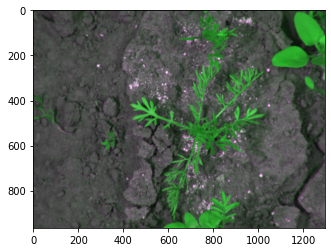

In [ ]:
for i in range(40):
    image = cv2.imread(image_path('images',i+1))
    plt.imshow(image)
    image_rescaled = cv2.resize(image, dsize=(216, 161), interpolation=cv2.INTER_CUBIC)
    label = label_generator(i+1)
    label_rescaled = cv2.resize(label, dsize=(216, 161), interpolation=cv2.INTER_CUBIC)
    print(label_rescaled.shape)
    x_train[i,:,:,:] = image_rescaled
    y_train[i,:,:,:] = label_rescaled
    x_train[40+i,:,:,:] = np.fliplr(image_rescaled)
    y_train[40+i,:,:,:] = np.fliplr(label_rescaled)
    x_train[80+1,:,:,:] = np.flipud(image_rescaled)
    y_train[80+i,:,:,:] = np.flipud(label_rescaled)

In [ ]:
x_test = np.zeros((20, 161, 216, 3))
y_test = np.zeros((20, 161, 216, 3))

In [ ]:
x_train[0]

array([[[46., 50., 46.],
        [44., 52., 44.],
        [47., 59., 47.],
        ...,
        [54., 74., 54.],
        [56., 63., 56.],
        [66., 75., 66.]],

       [[45., 52., 45.],
        [57., 60., 57.],
        [65., 61., 65.],
        ...,
        [60., 78., 60.],
        [67., 71., 67.],
        [53., 74., 53.]],

       [[46., 77., 46.],
        [48., 73., 48.],
        [51., 65., 51.],
        ...,
        [68., 76., 68.],
        [61., 71., 61.],
        [57., 78., 57.]],

       ...,

       [[84., 81., 84.],
        [71., 87., 71.],
        [75., 75., 75.],
        ...,
        [75., 77., 75.],
        [79., 75., 79.],
        [78., 87., 78.]],

       [[73., 72., 73.],
        [78., 85., 78.],
        [73., 85., 73.],
        ...,
        [77., 80., 77.],
        [69., 78., 69.],
        [66., 66., 66.]],

       [[86., 87., 86.],
        [81., 82., 81.],
        [83., 77., 83.],
        ...,
        [71., 74., 71.],
        [98., 95., 98.],
        [60., 78., 60.]]

In [ ]:
for i in range(20):
    image = cv2.imread(image_path('images',i+41))
    image_rescaled = cv2.resize(image, dsize=(216, 161), interpolation=cv2.INTER_CUBIC)
    label = label_generator(i+41)
    label_rescaled = cv2.resize(label, dsize=(216, 161), interpolation=cv2.INTER_CUBIC)
    x_test[i,:,:,:] = image_rescaled
    y_test[i,:,:,:] = label_rescaled

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
full_model = unet_res(n_classes=3)
full_model.compile(loss = 'binary_crossentropy',
             optimizer = 'Adam',
             metrics = [f1])

callbacks_full = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(patience=5, verbose=1),
    #ModelCheckpoint('model-full-cwfid.h5', verbose=1, save_best_only=True)
]

model_full_history = full_model.fit(x = x_train,
                         y = y_train,
                         batch_size = 5,
                         epochs = 30,
                         verbose = 1,
                         validation_split = 0.2,
                          callbacks = callbacks_full
                         )

Epoch 1/30
20/20 [==============================] - 19s 131ms/step - loss: 0.7126 - f1: 0.5722 - val_loss: 0.9716 - val_f1: 0.1321 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 1s 63ms/step - loss: 0.5460 - f1: 0.7007 - val_loss: 0.6551 - val_f1: 0.8656 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 1s 62ms/step - loss: 0.4841 - f1: 0.8260 - val_loss: 0.6301 - val_f1: 0.8456 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 1s 63ms/step - loss: 0.4289 - f1: 0.8980 - val_loss: 0.5730 - val_f1: 0.8470 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 1s 63ms/step - loss: 0.3812 - f1: 0.9068 - val_loss: 0.5393 - val_f1: 0.6578 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 1s 63ms/step - loss: 0.3370 - f1: 0.9299 - val_loss: 0.5753 - val_f1: 0.9259 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 1s 63ms/step - loss: 0.2998 - f1: 0.9470 - val_loss: 0.4821 - val_f1: 0.9280 - lr: 0.0010
Epoc

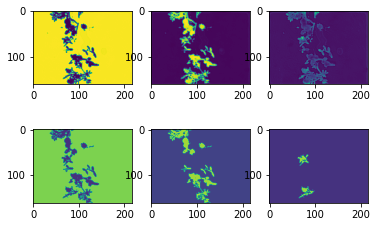

In [ ]:
i = 15
pred = full_model.predict(x_test)
plt.figure()
plt.subplot(2,3,1)
plt.imshow(pred[i,:,:,2])
plt.subplot(2,3,4)
plt.imshow(y_test[i,:,:,2])
plt.subplot(2,3,2)
plt.imshow(pred[i,:,:,1])
plt.subplot(2,3,5)
plt.imshow(y_test[i,:,:,1])
plt.subplot(2,3,3)
plt.imshow(pred[i,:,:,0])
plt.subplot(2,3,6)
plt.imshow(y_test[i,:,:,0])